# Example 2: How to pre- and postprocess CT data to estimate $CO_2$ saturation along a core sample

In [1]:
# Import libraries needed
import readers_preprocessing as rp
import plot_scans as ps
import co2_postprocessing as co

Let's read the data available to perform the processing
- Dry scans
- Wet scans
- Two-phase scans

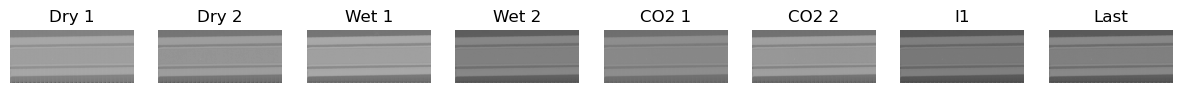

In [4]:
main_path = 'E:/GITHUB-DATA/EX1/'
# Dry scans
dry_1 = 'Dry_1/' ; dry_2 = 'Dry_2/'
# Wet scans
wet_1 = 'Br_1/' ; wet_2 = 'Br_2/'
# CO2 scans
co1 = 'CO_1/' ; co2 = 'CO_2/'
# 2-phase scans
m2 = 'M_2/' ; last = 'last/'

# Read dicom files
d1 = rp.read_dicom(main_path + dry_1) ; d2 = rp.read_dicom(main_path + dry_2)
w1 = rp.read_dicom(main_path + wet_1) ; w2 = rp.read_dicom(main_path + wet_2)
c1 = rp.read_dicom(main_path + co1) ; c2 = rp.read_dicom(main_path + co2)
m2 = rp.read_dicom(main_path + m2) ; last = rp.read_dicom(main_path + last)

# Compare scans
sdict = {'Dry 1':d1,'Dry 2':d2,'Wet 1':w1,'Wet 2':w2,'CO2 1':c1,'CO2 2':c2,'I1':m2,'Last':last}
ps.compare_scans(sdict)


As a good practice it is recommended to center all scans for consistency, even though we are centering, for this dataset it is not required to use a volume registration routine

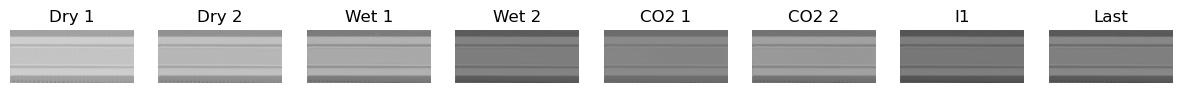

In [5]:
# center images 
d1a = rp.center_itk(d1,265,259,244,261) ; d2a = rp.center_itk(d2,265,259,244,261)
w1a = rp.center_itk(w1,265,259,243,255) ; w2a = rp.center_itk(w2,265,259,243,255)
c1a = rp.center_itk(c1,265,259,243,255) ; c2a = rp.center_itk(c2,265,259,243,255)
m2a = rp.center_itk(m2,265,259,243,255) ; lsa = rp.center_itk(last,265,259,243,255)

# Compare scans
sdict = {'Dry 1':d1a,'Dry 2':d2a,'Wet 1':w1a,'Wet 2':w2a,'CO2 1':c1a,'CO2 2':c2a,'I1':m2a,'Last':lsa}
ps.compare_scans(sdict)

Once the scans are centered/aligned, it is always necessary to extract only the core sample data. We can use the function `readers_preprocessing.mask_images(*args)`

In [7]:
# crop dry images
d1m = rp.mask_images(d1a,67,1,1196) ; d2m = rp.mask_images(d2a,67,1,1196)
w1m = rp.mask_images(w1a,67,1,1196) ; w2m = rp.mask_images(w2a,67,1,1196)
c1m = rp.mask_images(c1a,67,1,1196) ; c2m = rp.mask_images(c2a,67,1,1196)
m2m = rp.mask_images(m2a,67,1,1196) ; lsm = rp.mask_images(lsa,67,1,1196)

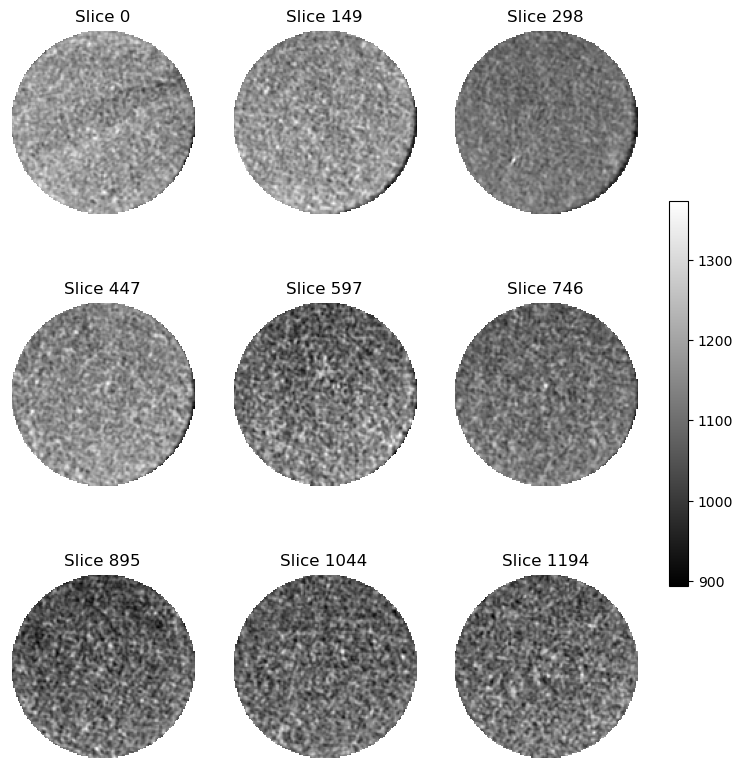

In [8]:
# Plot slices
ps.plot_slices(d1m,3,3)

As a first assesment of uncertainty, let's plot histograms for each dry and wet sample. This analysis will suggest the need for a voxel coarsening scheme.
This function is available in the `plot_scans.py` file as `plot_scans.plot_multiple_histograms()`

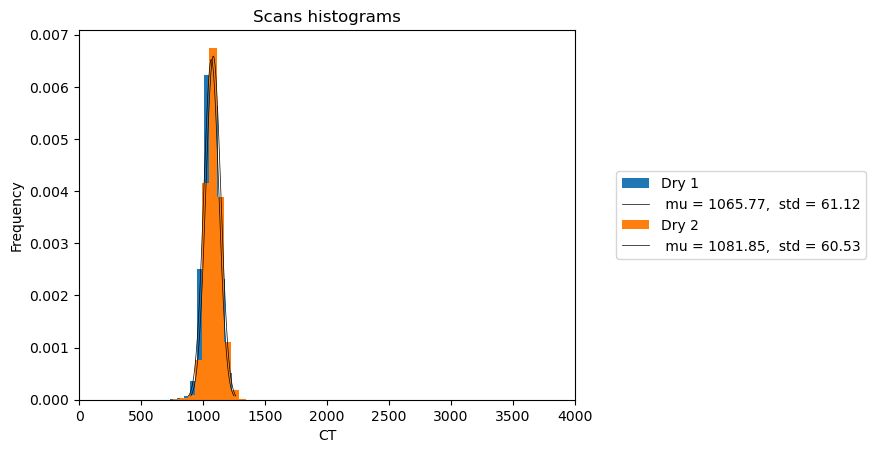

In [9]:
# Histograms for different slices
mdict = {'Dry 1':d1m,'Dry 2':d2m}
ps.plot_multiple_histograms(mdict)

Another way to estimate uncertainty is to calculate the standard deviation of the difference between two different scans of the same sample

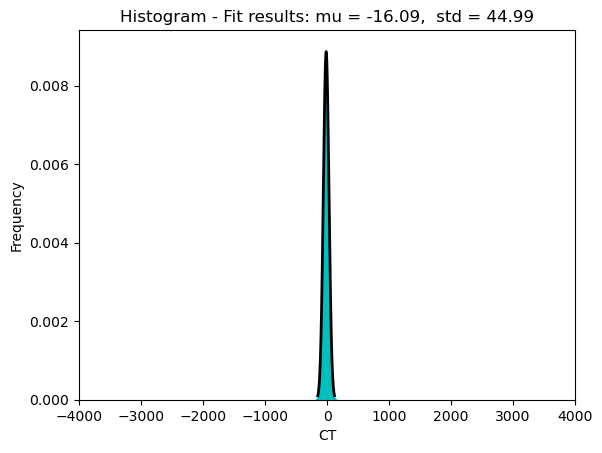

In [10]:
# Difference between dry samples
dry_diff = d1m - d2m

# plot histogram
ps.histogram(dry_diff)

To reduce the uncertainty in the sample, we use Pini and Benson scheme slice averaging and voxel coarsening. Different core samples/experiments may have different coarsening techniques or averaging for this example we will coarsen the voxels (1mmx1mmx1mm)


In [12]:
# We recommend to average the scans first
davg = (d1m + d2m)/2
wavg = (w1m + w2m)/2
cavg = (c1m + c2m)/2

# Coarsen scheme
dcoarse = rp.resample(davg,5,[1,1,1])
wcoarse = rp.resample(wavg,5,[1,1,1])
ccoarse = rp.resample(cavg,5,[1,1,1])
m2coarse = rp.resample(m2m,5,[1,1,1])
lscoarse = rp.resample(lsm,5,[1,1,1])

# We want to erase the edges of the images, because they are affected by the zero values of the background
df = rp.mask_images(dcoarse,10,1,1196)
wf = rp.mask_images(wcoarse,10,1,1196)
cf = rp.mask_images(ccoarse,10,1,1196)
m2f = rp.mask_images(m2coarse,10,1,1196)
lsf = rp.mask_images(lscoarse,10,1,1196)


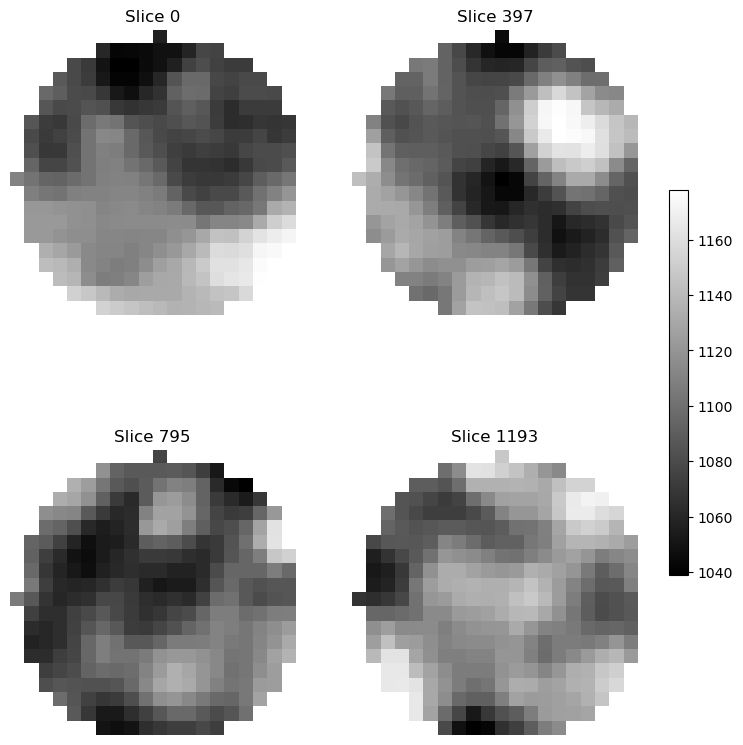

In [13]:
# Plot coarsen slices
ps.plot_slices(df,2,2)

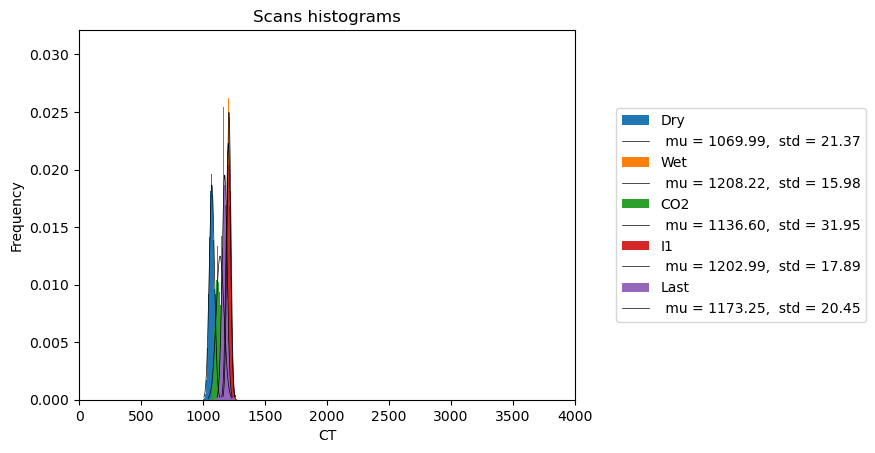

In [14]:
# Plot histograms of the coarsen scans
fdict = {'Dry':df,'Wet':wf,'CO2':cf,'I1':m2f,'Last':lsf}
ps.plot_multiple_histograms(fdict)

In some scenarios, it is worth it to examinate the CT number along the whole core sample. To do this you can call the function `z_profiling` available in the `plot_scans.py` file

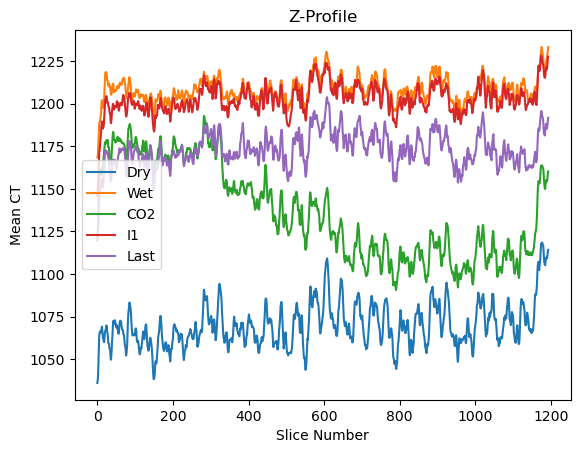

In [15]:
# Compare scans
z_profiles = ps.z_profiling(fdict)

Standard deviation is reduced by half compared to uncoarsen scans, the uncertainty is reduce even more if we average more scans of the same sample

### Porosity estimation

For this specific example, it is needed to estimate porosity in the sample. Three different schemes can be used to estimate porosity: core-, slice- and voxel-level porosity. 
The routines file `co2_postprocessing.py` contains functions for both porosity and saturation (`co2_postprocessing.porosity(*args)`)

Core level porosity estimate: 0.138


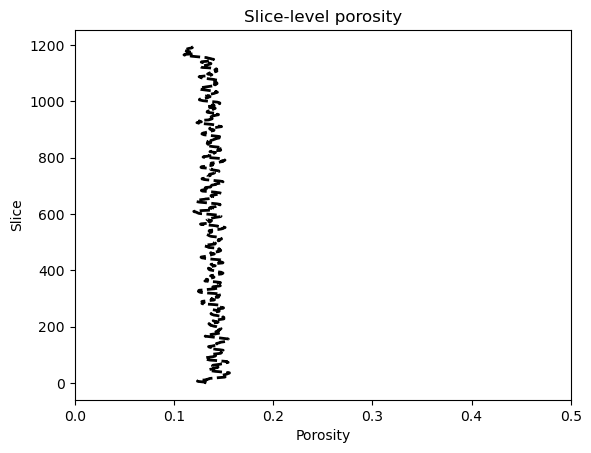

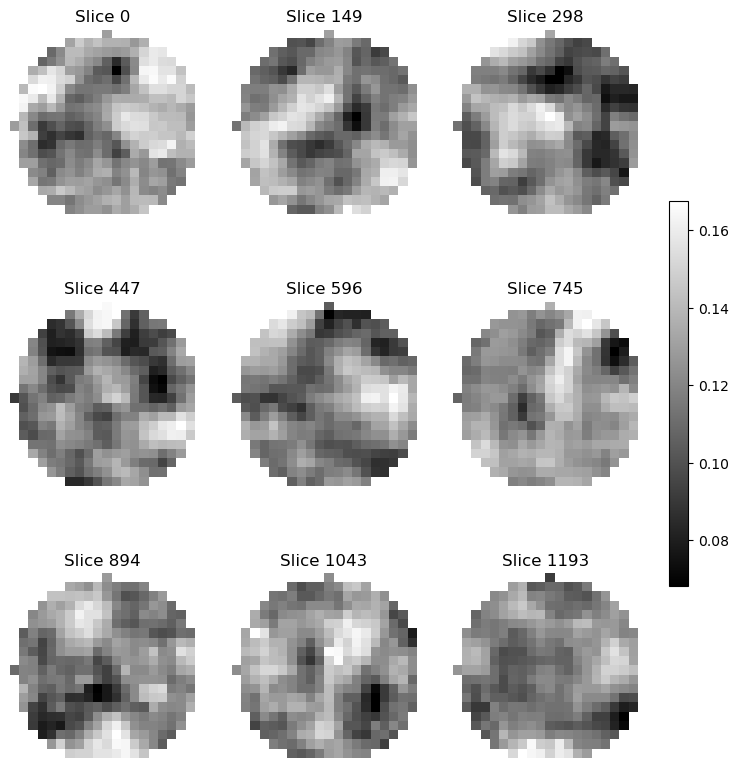

In [16]:
# Use function porosity
core_por = co.core_level_porosity(df,wf)
slice_por = co.slice_level_porosity(df,wf)
voxel_por = co.voxel_level_porosity(df,wf)

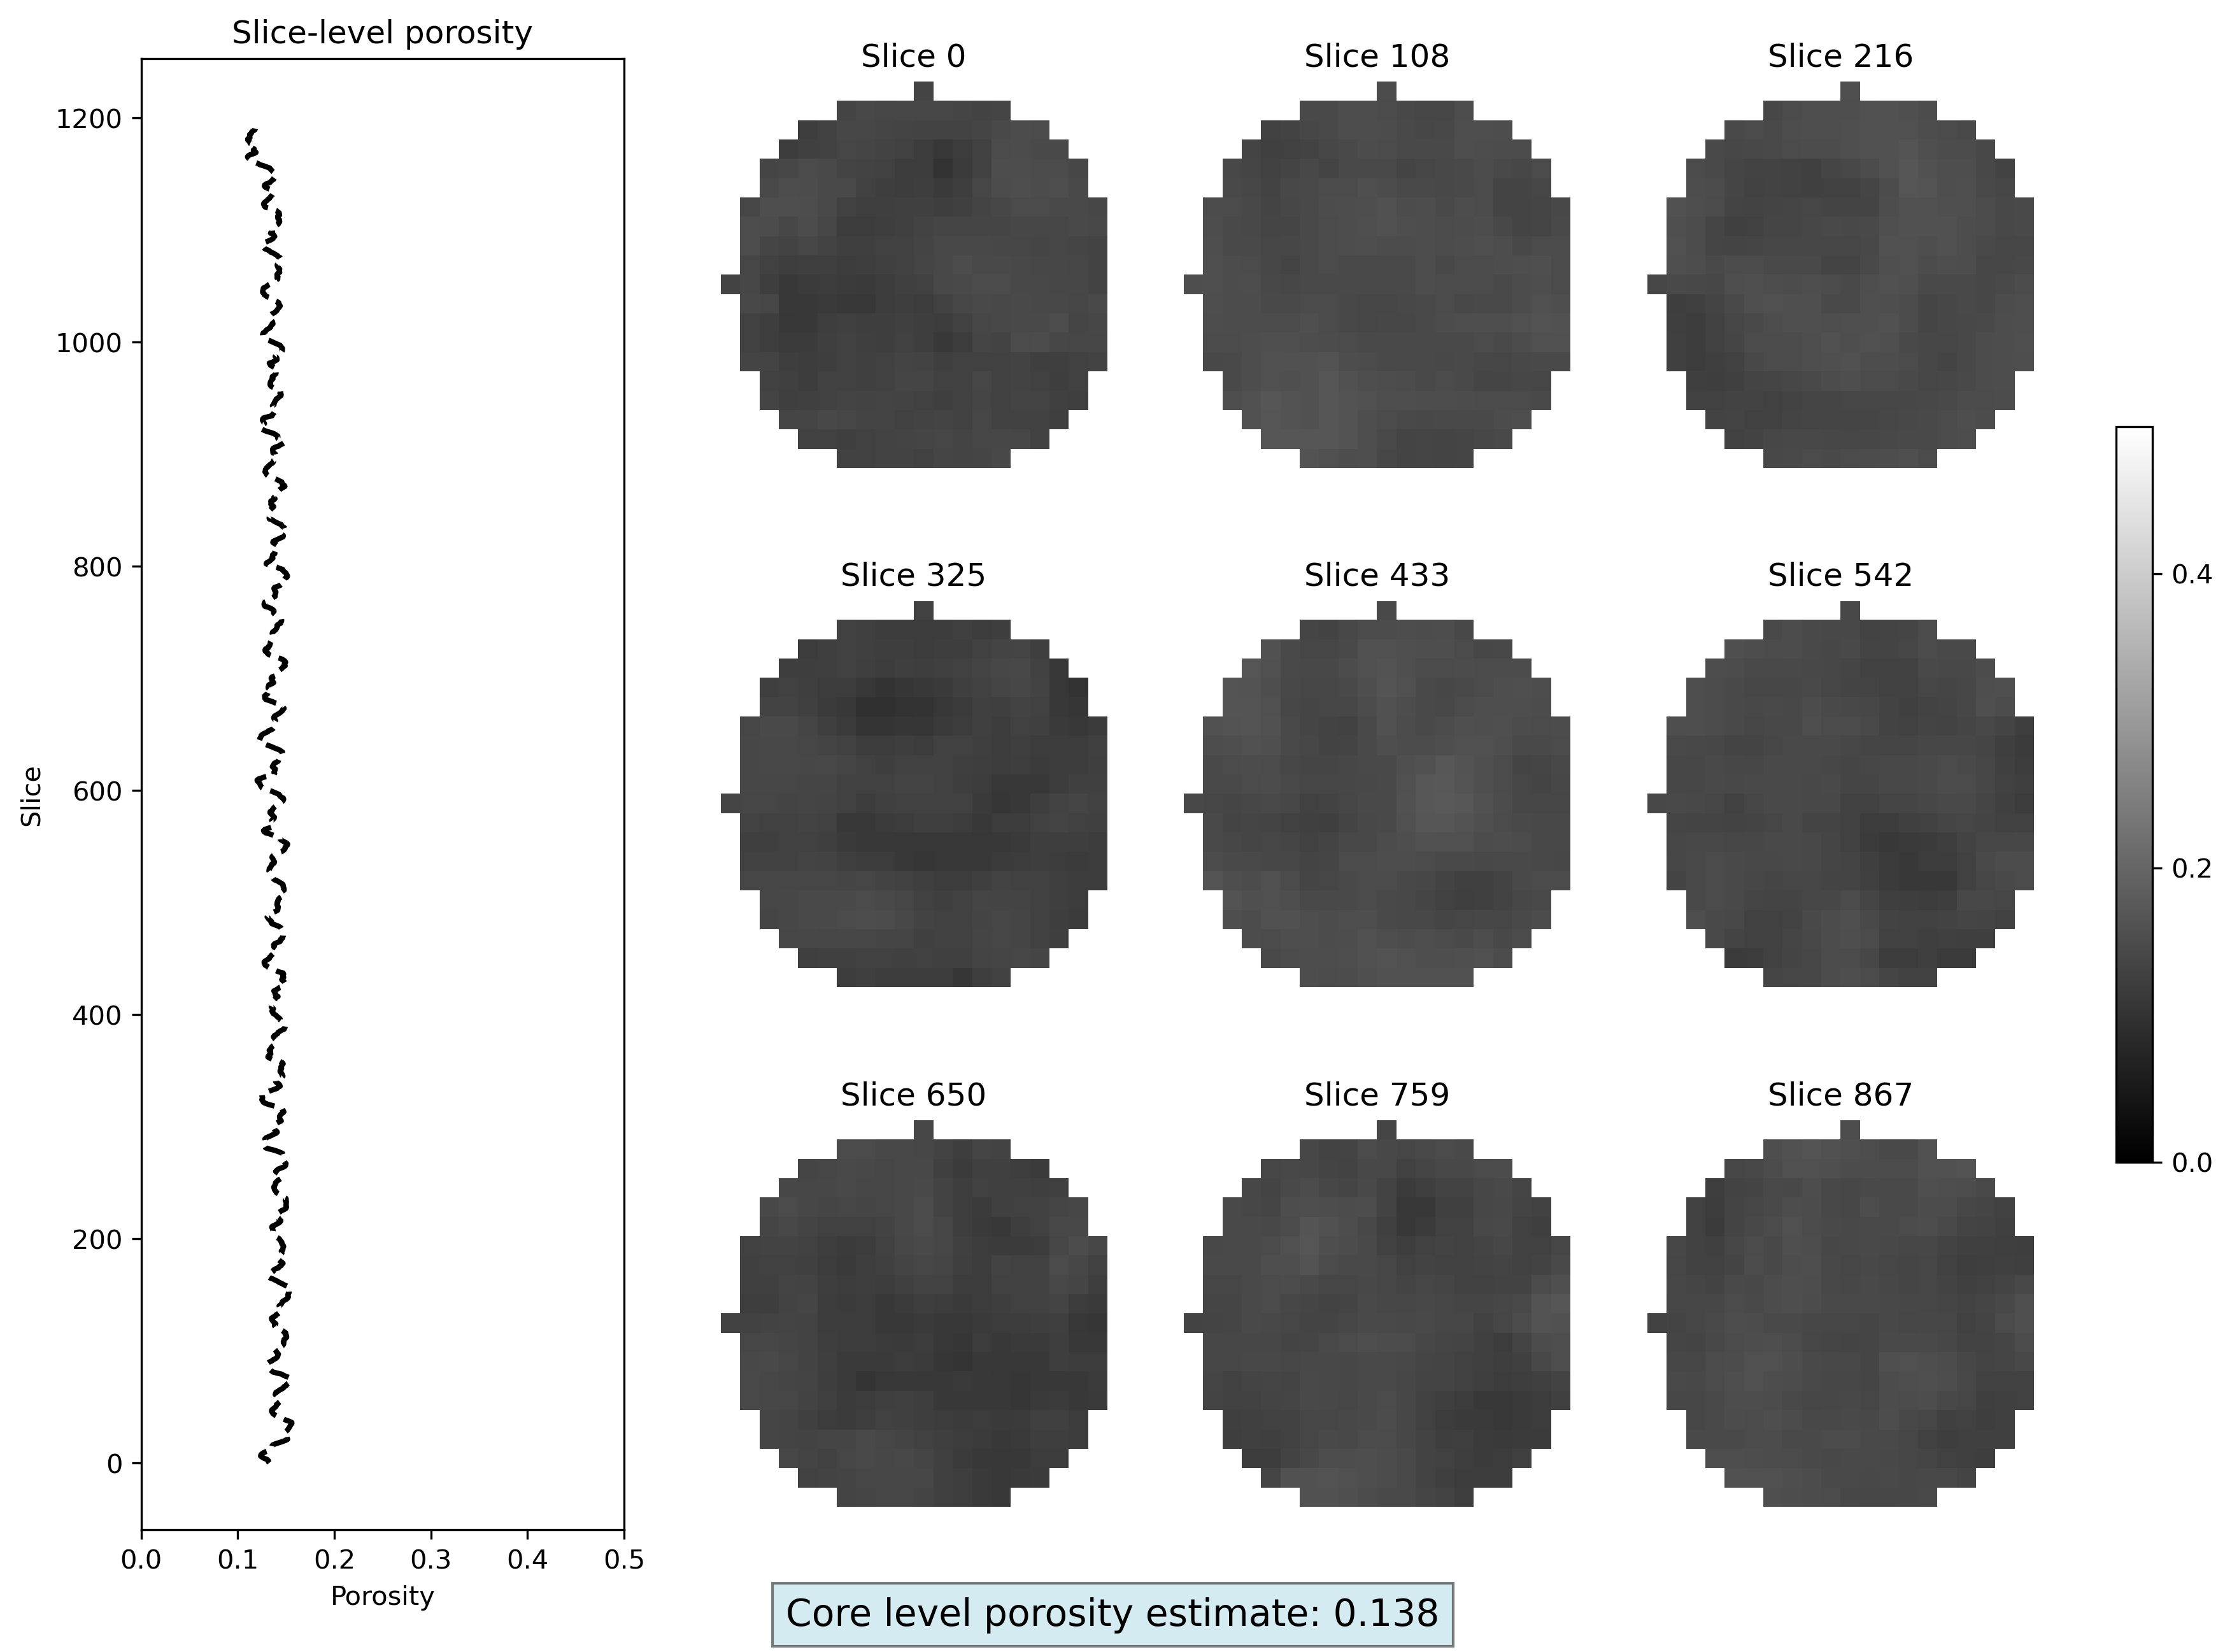

In [17]:
co.dashboard_porosity(core_por,slice_por,voxel_por)

### Saturation estimation

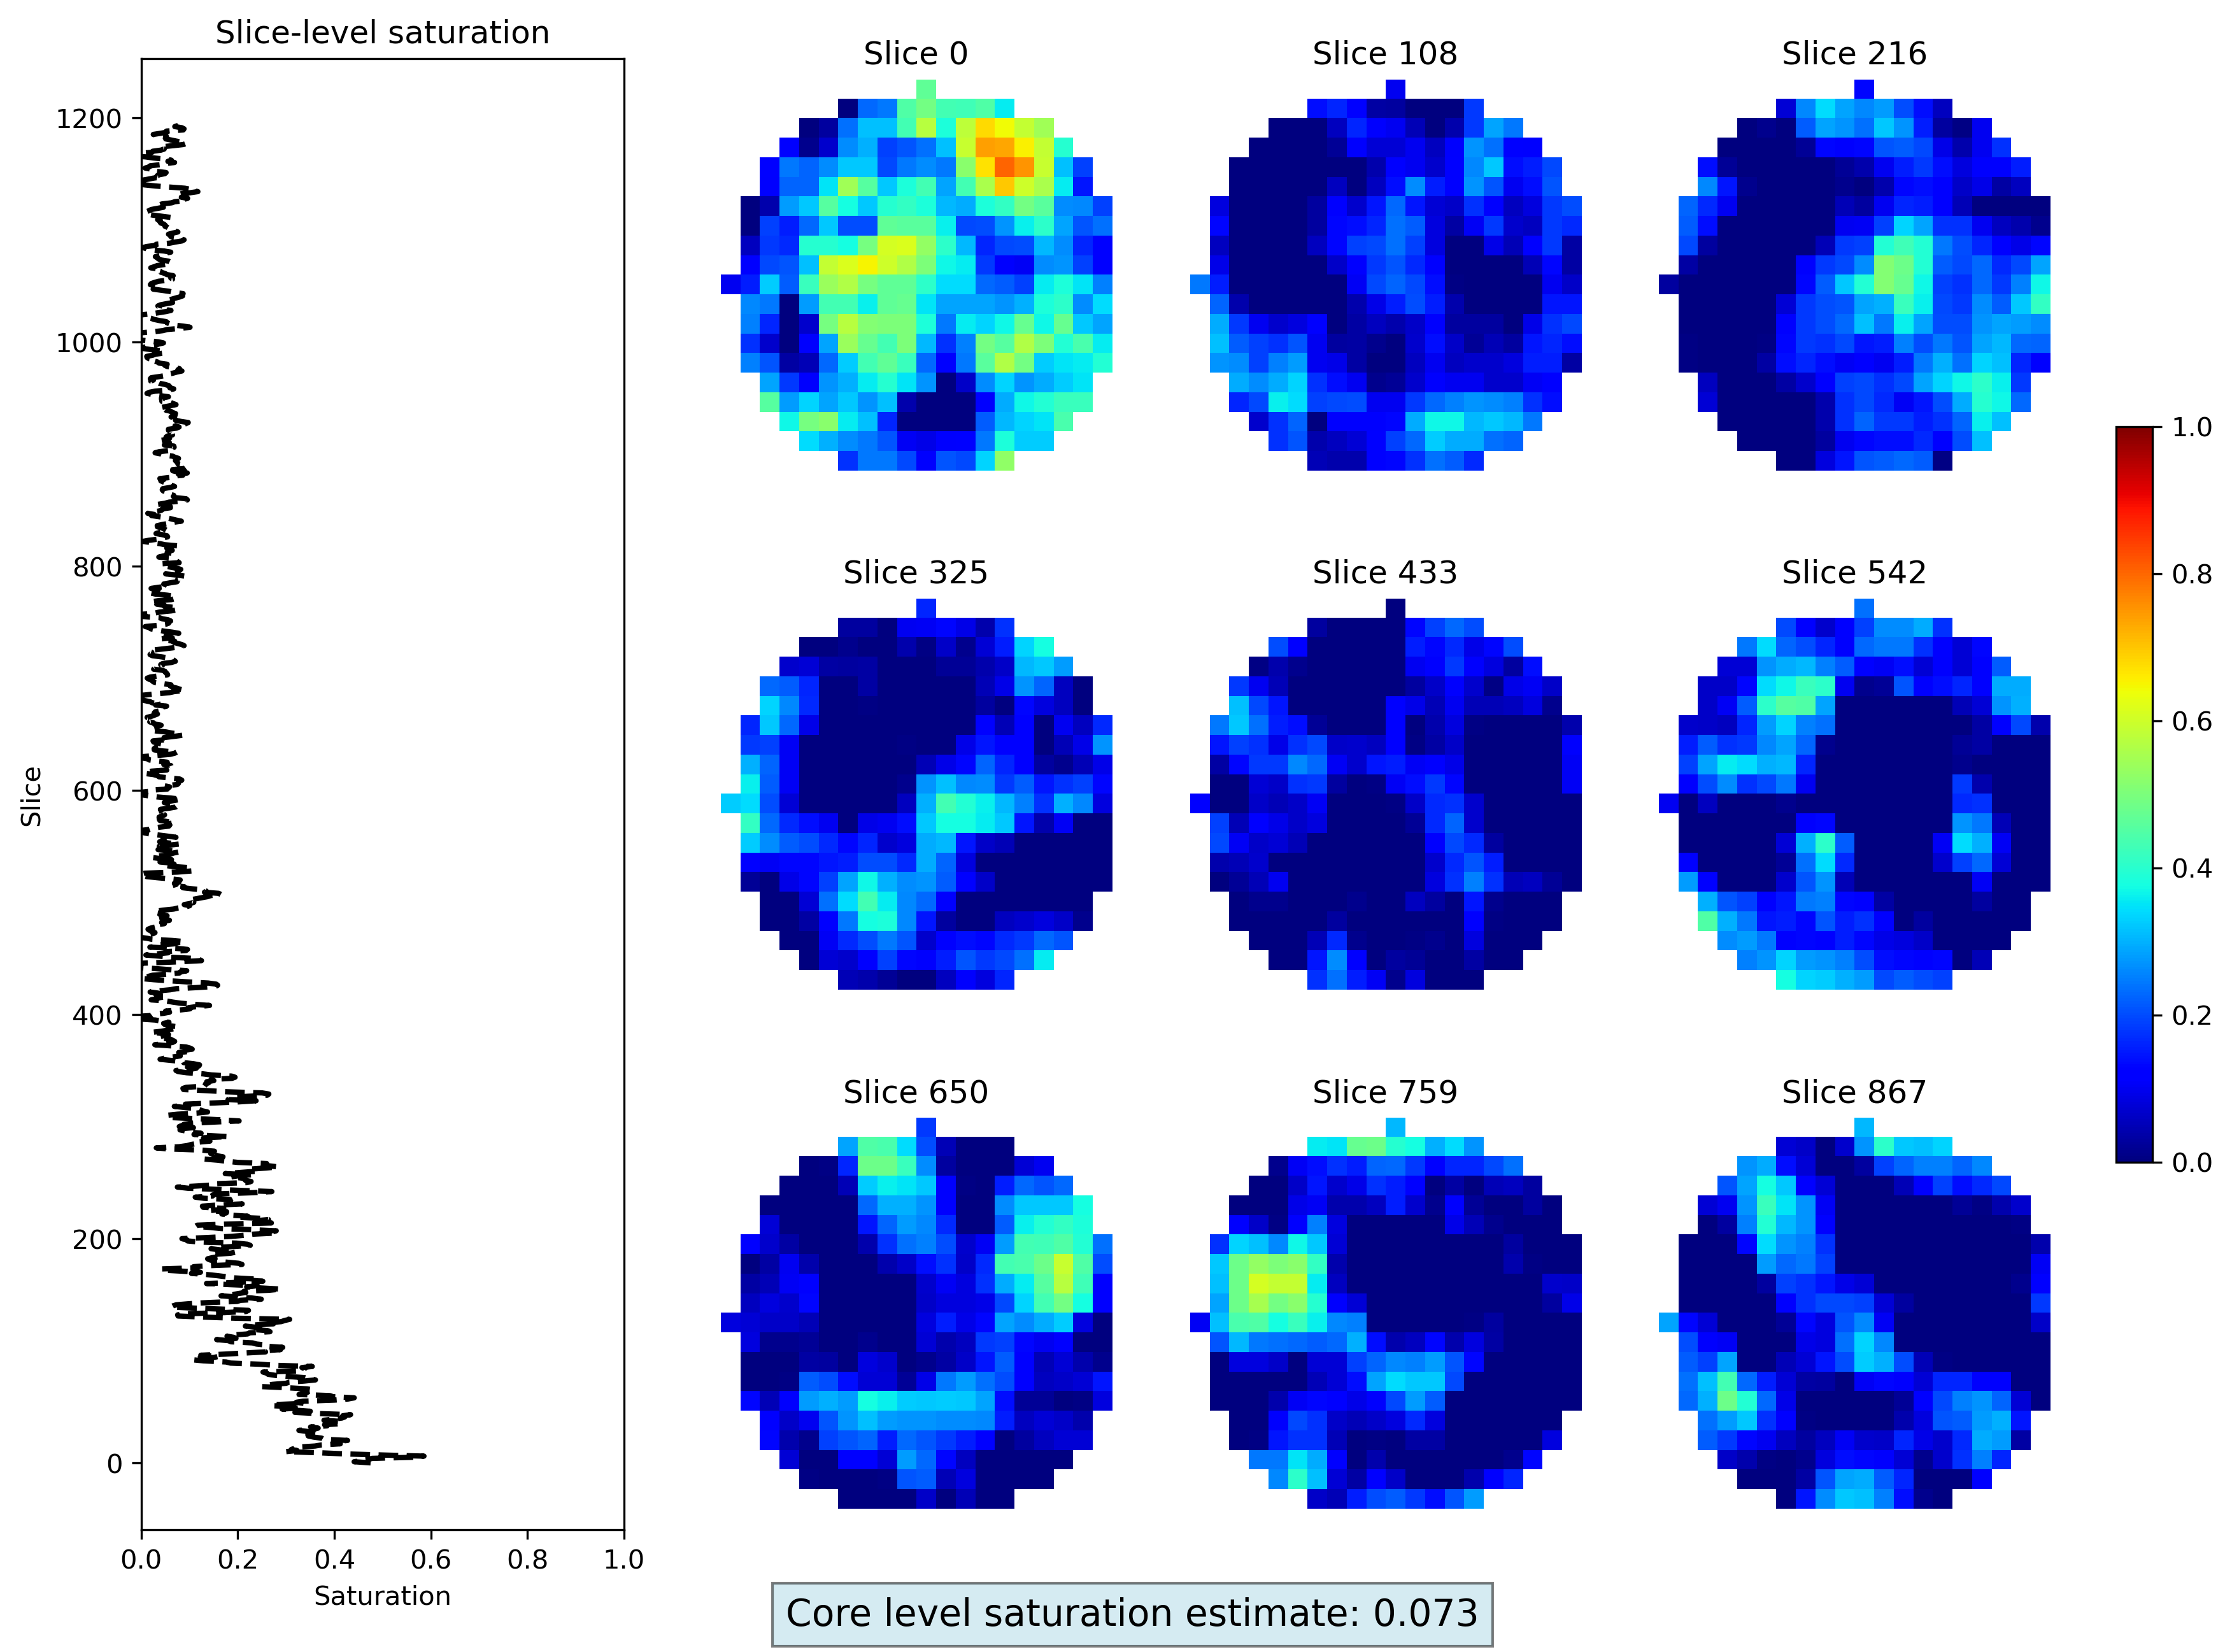

In [18]:
# Use function saturation to estimate the saturation of the sample
co.dashboard_saturation(wf,cf,m2f)